# Synapsica Assignment
Prepared By: Jay Pratap \\
Date of Submission: September 23, 2022


## Content


*   Problem statement
*   Data
*   Possible Solutions
*   Applied Method 
*   Implementation
      *  Reference Generation
      *  Testing
*   possible Improvements



##Problem Statement
Estimation of length of CANAL in vertebrae cross section in images

## Data
Images


*   Original Images: 11 grayscale 
*   Tagged images: 11 with a line along the length of canal
*   Image Size: 230 X 320


## Possible Solutions
Since objective is to estimate the length of the canal as described. We can estimate the position of 2 extreme points and then calculate the length between them.
Now problem is reduced to indentification of 2 extreme points. \\
There are might be several methods for the same, \\
1. Statistical and hand-crafted feature based methods
2. Feature extraction (especially Deep learning) Based methods 

### Statistical and hand-crafted feature based methods
There are lot of methods to extract hand crafted features like edges, corners etc. 

* Advantages
    * When data has low variance these can work very well
    * Less data points are required to create as compare to Machine/deep learning based methods.
    * Lesser parameters to be fine tuned as compared to deep learning based methods.
* Disadvantage
    * These may not as flexible as other methods.
    * Small noise can affect the performances

### Feature extraction (especially Deep learning) Based methods
There are lot of methods for object detection and image segmentation, keyoint detection are available. 

* Advantage
    * Flexibility and robustness for small changes in data and noise

* Disadvantage
    * Need of lot of data for training
    * Lot of experimentation are required to finetune the model
    * These are more costly in development and deployment


## Solution used in assignment
For given situation
* Less datapoints (Images): Not enough data to train any ML/DL model
* Cost: 
    * For estimation of position of only 2 points in an image of size 230 X 320, using complex Machine/deep learning model will not be appropriate.
    * If scope would have broader then it would be logical to use image segmentaion, bounding box detection, or keypoints detection using deep learning. 

Keeping all in mind I have chosen method of Hand-crafted features with some innovations.



## Applied Method
SIFT is a hand crafted feature extractor which is very successful in stitching photographs. It estimate ciritcal points using Laplacian of Gaussian (LoG) at multiple scale and resolution. And estimates point descriptors using slope histograms. \\
Sift features are translation and scale invarient.

###Steps
1. Aggregation of reference features

    1. Using tagged images find extreme points for each image.
    2. Estimate keypoints and corresponding SIFT Descriptors (features) for image
    3. Get Sift descriptors for nearest keypoints to extreme points on canal in image
    4. A threshold is used for distance of nearest keypoint to canal points to select better representation and reject others. 
    5. Aggregate the features for extreme keypoints (2 different set of features aggregated for 2 extreme points of canal)

2. Application
    1. Estimate SIFT keypoints and descriptors for an image (We need to estimate around 200 points so that we do not lose canal points)
    2. Comparing descriptors with reference descriptors and using threshold, find potential extreme points of canal (2 sets, one for each extreme point)
    3. Pair points from 2 sets and selet potential pairs of extreme points based on threshold of maximum distance between them. 
    4. Filter out the pair based on there relative orientation 




## Experiments and Implementation  

In [25]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
import yaml

def get_configuration_dict(config_yaml_path):
  """
  This function read configuration YAML file and provide dictionary with configuration

  parameters:
      -config_yaml_path: path of the yaml file having configuration

  return:
      -config_dict: diction having key- value pairs for configuration
  """
  with open(config_yaml_path, "r") as stream:
      try:
          config_dict = yaml.safe_load(stream)
          return config_dict
      except yaml.YAMLError as exc:
          print(exc)

In [27]:
import os
import shutil
def data_dir_prep(config_dict):
  """
  This function prepare data for usage
  
  parameters:
      -config_dict: configuration dictionary as created from YAML file

  return:
      -config_dict: updated for original and tagged image directories
  """
  try:

    shutil.copy(config_dict["DATA_ZIP_PATH"], config_dict["WORKING_DIR"])
    shutil.unpack_archive(config_dict["WORKING_DIR"]+"/"+config_dict["DATA_ZIP_PATH"].split("/")[-1], config_dict["WORKING_DIR"])
    config_dict["TAGGED_IMAGE_DIR"] = config_dict["WORKING_DIR"]+"/assignment_dataset/tagged_images/"
    config_dict["ORIGINAL_IMAGE_DIR"] = config_dict["WORKING_DIR"]+"/assignment_dataset/original_images"
    return config_dict
  except:
    print("Not able to create directory structure.")

In [28]:
import glob
import cv2
import numpy as np
import pandas as pd
def prep_reference_df(config_dict):
  """
  This function prepares reference dataframe
  
  parameters:
      -config_dict: configuration dictionary

  return:
      -df_reference: dataframe with original and tagged file paths and corresponding reference start and end points

  """
  # list_original_image_files = glob.glob(config_dict["ORIGINAL_IMAGE_DIR"]+"/*")
  list_tagged_image_files = glob.glob(config_dict["TAGGED_IMAGE_DIR"]+"/*")
  df_reference = pd.DataFrame(columns=["Original_Image_Path", "Tagged_Image_Path", "Start_Point", "End_Point"])

  for image_file in list_tagged_image_files:
    img = cv2.imread(image_file)
    bw_img = (img[:,:,0]>250) * (img[:,:,1]<20) 
    points = np.where(bw_img==1)
    start_point = (points[1][0], points[0][0])
    end_point = (points[1][-1], points[0][-1])
    list_name = image_file.split("/")
    list_name[3] = "original_images"
    list_name[-1] = list_name[-1].split("_")[-1]
    org_image_path = "/".join(list_name)
    df_reference.loc[len(df_reference.index)] = [org_image_path, image_file, start_point, end_point]
  return df_reference

In [29]:
import cv2
import numpy as np
def image_enhancement(image):
  """
  This function take the image and enhance it with various ways

  parameters:
      -image: numpy array of image

  return:
      -image: numpy array of image
  """
  min = np.amin(image)
  max = np.amax(image)
  enhanced_image = (255/(max-min))*(image-min)
  return enhanced_image.astype("uint8")

In [30]:
import numpy as np
import cv2


def euclidean_distance(point1, point2):
  """
  parameters:
      -point1: numpy array having x,y
      -point2: numpy array having x,y
    
  return:
      -distance: float, distance between input points
  """
  try:

    distance = (np.sum((point1-point2)**2))**.5
    return distance
  except:
    print("Problem in calculating euclidean distance. Check the point numpy arrays.")



def reference_feature_extraction(config_dict, df_reference):
  """
  This function extract and saves reference SIFT features

  parameters:
      -df_reference: reference dataframe with original and tagged file paths with corresponding refereence start and end points

  output:
      -start_point_features.npy: file having start point features
      -end_point_features.npy: file having end point features
  """
  # try:
  np_features_start = []
  np_features_end = []
  feature_extractor = cv2.SIFT_create() 
  # nfeatures = 1,
  #                                     nOctaveLayers = 3,
  #                                     contrastThreshold = 0.04,
  #                                     edgeThreshold = 10,
  #                                     sigma = 1.6 )    #(nfeatures=1500)

  for row in df_reference.iterrows():
    img = cv2.imread(row[1][0], cv2.IMREAD_GRAYSCALE)
    img = image_enhancement(img)
    # # img.reshape(img.shape[0], img.shape[1])
    keypoints, descriptors = feature_extractor.detectAndCompute(img, None)
    reference_start_point = row[1][2]
    reference_end_point = row[1][3]
    list_dist_start = []
    list_dist_end = []
    point_list = []
  
    for point in keypoints:
      point_list.append(point.pt)
      list_dist_start.append(euclidean_distance(np.array(reference_start_point), np.array(point.pt)))
      list_dist_end.append(euclidean_distance(np.array(reference_end_point), np.array(point.pt)))
    min_dist_start = min(list_dist_start)
    min_dist_end = min(list_dist_end)
    ind_start = list_dist_start.index(min_dist_start)
    ind_end = list_dist_end.index(min_dist_end)

    if min_dist_start<5 and min_dist_end<5:
      np_features_start.append(descriptors[ind_start])
      np_features_end.append(descriptors[ind_end])
    np.save(config_dict["REFERENCE_FEATURE_PATH"]+"/start_point_features.npy", np.array(np_features_start))
    np.save(config_dict["REFERENCE_FEATURE_PATH"]+"/end_point_features.npy", np.array(np_features_end))
  return

  # except:
  #   print("Error in feature extraction.")


In [56]:
from google.colab.patches import cv2_imshow
def hamming_distance(n1, n2):
  """
  This function gives Hamming deistance between two given numbers

  parameters:
      -n1, n2: two integers

  Return:
      -setBits: Hamming distance  
  """
  x = n1 ^ n2
  setBits = 0
  while (x > 0) :
      setBits += x & 1
      x >>= 1
  return setBits


def list_hamming_distance(list1, list2):
  """
  This function gives hamming distance between 2 vectors of integers

  parameters:
      -list1, list2: lists of integers

  returns:
      -ham_dist: Hamming distance between lists
  """
  zip_list = zip(list1, list2)
  ham_dist=0
  for l1, l2 in zip_list:
    ham_dist += hamming_distance(l1, l2)
  return ham_dist

def best_predicted_point(reference_feature, predicted_keypoints, predicted_descriptors, config_dict):
  """
  This function select best predicted points for given feature of a single reference point based on  distance threshold

  parameters:
      -reference_feature: numpy array with single reference feature
      -predicted_keypoints: numpy array
      -predicted_descriptors: numpy array
      -config_dict: dictionary with configuration

  returns:
      -selected_points: seleced keypoints array
      -selected_descriptors: descriptors corresponding to selected points
      -selected_distances: distance corresponding to selected points
      -unselected_points: rejected points array
      -unselected_descriptors: descriptors corresponding to rejected points
      -unselected_distances: distance corresponding to rejected points
  """
  selected_points = []
  selected_descriptors = []
  selected_distances = []

  unselected_points = []
  unselected_descriptors = []
  unselected_distances = []
  zip_point_des = zip(predicted_keypoints, predicted_descriptors)
  for point, descriptor in zip_point_des:
    distance = euclidean_distance(reference_feature, descriptor)
    if distance < config_dict["EUCLIDEAN_DISTANCE_MAX_THRESHOLD"]: # and distance>config_dict["EUCLIDEAN_DISTANCE_MIN_THRESHOLD"]:  #min_distance:
      selected_points.append(point)
      selected_descriptors.append(descriptor)
      selected_distances.append(distance)
    else:
      unselected_points.append(point)
      unselected_descriptors.append(descriptor)
      unselected_distances.append(distance)

  return selected_points, selected_descriptors, selected_distances, unselected_points, unselected_descriptors, unselected_distances

def point_selection_and_ref(reference_features, predicted_keypoints, predicted_descriptors, config_dict):
  """
  This function gives keypoints whose descriptors with in threshold from all reference descriptors

  parameters:
      -reference_features: Array of all reference features
      -predicted_keypoints: predicted keypoints array
      -predicted_descriptors: descriptors corresponding to predicted keypoints
      -config_dict: dictionary with configuration

  returns:
      -all_selected_points: All the points which satisfy the threshold from all the reference descriptors 
      -all_selected_descriptors: corresponding descriptors
      -all_selected_distances: corresponding distances
  """
  is_first_instance = True
  for feat in reference_features:
    # min_descriptor, min_point, min_distance = hamming_best_point(feat, predicted_keypoints, predicted_descriptors, config_dict)
    if is_first_instance:
      selected_points, selected_descriptors, selected_distances,_,_,_ = best_predicted_point(feat, predicted_keypoints, predicted_descriptors, config_dict)
      is_first_instance = False
    else:
      selected_points, selected_descriptors, selected_distances,_,_,_ = best_predicted_point(feat, selected_points, selected_descriptors, config_dict)
  return selected_points, selected_descriptors, selected_distances


def point_selection_or_ref(reference_features, predicted_keypoints, predicted_descriptors, config_dict):
  """
  This function gives keypoints whose descriptors with in threshold from any one reference descriptors

  parameters:
      -reference_features: Array of all reference features
      -predicted_keypoints: predicted keypoints array
      -predicted_descriptors: descriptors corresponding to predicted keypoints
      -config_dict: dictionary with configuration

  returns:
      -all_selected_points: All the points which satisfy the threshold from any one of the reference descriptors 
      -all_selected_descriptors: corresponding descriptors
      -all_selected_distances: corresponding distances 
  """
  pred_des = predicted_descriptors
  pred_keyp = predicted_keypoints
  all_selected_points = []
  all_selected_descriptors = []
  all_selected_distances = [] 
  for feat in reference_features:
    selected_points, selected_descriptors, selected_distances, pred_keyp, pred_des,_ = best_predicted_point(feat, pred_keyp, pred_des, config_dict)
    all_selected_points += selected_points
    all_selected_descriptors += selected_descriptors
    all_selected_distances += selected_distances
  return all_selected_points, all_selected_descriptors, all_selected_distances

def point_pairs_selection(start_points, start_distances, end_points, end_distances, config_dict):
  """
  This function gives pairs of extreme points of canal based on distance threshold between points. here points are point objects given by cv2 SIFT

  parameters:
      -start_points: array of start point (one of the canal extreme point)
      -start_distances: array of corresponding distances
      -end_points: array of end points (another canal extreme point)
      -end_distances: array of distances corresponding to end points
      -config_dict: configuration dictionary

  returns:
      -selected_pairs: all pairs of point objects which satisfied the threshold
  """
  selected_pairs = []
  for s_point in start_points:
    for e_point in end_points:
      euclid_distance = euclidean_distance(np.array(s_point.pt), np.array(e_point.pt))
      # print("Eu distance: ", euclid_distance)
      if euclid_distance<config_dict["PAIR_DISTANCE_MAX_THRESHOLD"] and euclid_distance>config_dict["PAIR_DISTANCE_MIN_THRESHOLD"]:
        selected_pairs.append([s_point, e_point])
  return selected_pairs

def pair_alignment_filter(point_pair, config_dict):
  """
  This funtions checks alignment of point pairs

  parameters:
      -point_pair: list of 2 point objects
      -config_dict: configuration dictionary

  return:
  True or False based on comparison with threshold
  """
  s_point = point_pair[0].pt
  e_point = point_pair[1].pt
  if np.abs(s_point[0]-e_point[0])<config_dict["PAIR_ALIGNMENT_THRESHOLD"]:
    return True
  # elif np.abs(s_point[1]-e_point[1])<config_dict["PAIR_ALIGNMENT_THRESHOLD"]:
  #   return True
  else:
    return False


def predict_points(df_ref, config_dict):
  """
  This function gives final prediction of points

  parameters:
      -df_ref: dataframe having paths of image files
      -config_dict: configuration dictionary
  """
  feature_extractor = cv2.SIFT_create()
  np_st = np.load(config_dict["REFERENCE_START_POINT_FEATURE_PATH"])
  np_en = np.load(config_dict["REFERENCE_END_POINT_FEATURE_PATH"])
  df_output = pd.DataFrame(columns=["Image_file_path", "Length_of_Canal"])
  for row in df_ref.iterrows():
    img = cv2.imread(row[1][0], cv2.IMREAD_GRAYSCALE)
    keypoints, descriptors = feature_extractor.detectAndCompute(img, None)

    start_points, _, start_distances = point_selection_or_ref(np_st, keypoints, descriptors, config_dict)
    end_points, _, end_distances = point_selection_or_ref(np_en, keypoints, descriptors, config_dict)
    # print("Number of start points: ", len(start_points))
    # print("Number of end points: ", len(end_points))
    selected_pairs = point_pairs_selection(start_points, start_distances, end_points, end_distances, config_dict)
    final_pair_num = 0
    final_pairs_distance = []
    for point_pair in selected_pairs:
      if pair_alignment_filter(point_pair, config_dict):
        final_pair_num += 1
        final_pairs_distance.append(euclidean_distance(np.array(point_pair[0].pt), np.array(point_pair[1].pt)))
        img = cv2.circle(img, [round(_) for _ in point_pair[0].pt], 1, (250,0,0), 2)
        img = cv2.circle(img, [round(_) for _ in point_pair[1].pt], 1, (250,0,0), 2)
    df_output.loc[len(df_output.index)] = [row[1][0], np.mean(final_pairs_distance)]
  df_output.to_csv(config_dict["OUTPUT_FILE_PATH"])
    

In [57]:
def create_reference_files(yaml_file_path):
  """
  This fundtion works as main funtion for reference creation
  """
  config_dict = get_configuration_dict(yaml_file_path)
  config_dict = data_dir_prep(config_dict)
  df_ref = prep_reference_df(config_dict)
  reference_feature_extraction(config_dict, df_ref)
  return 


def prep_test_df(config_dict):
  """
  This function prepares test dataframe
  
  parameters:
      -config_dict: configuration dictionary

  return:
      -df_reference: dataframe with original and tagged file paths and corresponding reference start and end points

  """
  list_original_image_files = glob.glob(config_dict["ORIGINAL_IMAGE_DIR"]+"/*")
  df_test = pd.DataFrame(list_original_image_files, columns=["Original_Image_Path"])
  return df_test

def test_model(yaml_file_path):
  """
  This function is to test model. this will save output csv to given path
  """
  config_dict = get_configuration_dict(yaml_file_path)
  config_dict = data_dir_prep(config_dict)
  df_test = prep_test_df(config_dict)
  predict_points(df_test, config_dict)
  return 

# testing
Instructions:
* To create reference files (npy) (already saved files can also be used)
    * Create a zip file with named "assigment_dataset" and keep "original_images" and "tagged_images" in corresponding folders.
    * Now Edit paths of zip file, working directory(codes will run in this directory), main directory(file will be saved in this directory) in YAML configuration file 
    * Edit other parameters if needed
    * Run the create_reference_files
* Testing (To create output csv file with canal length estimations)
    * Create a zip file with named "assigment_dataset" and keep "original_images" and "tagged_images" in corresponding folders.
    * Now Edit paths of zip file, working directory(codes will run in this directory), main directory(file will be saved in this directory) in YAML configuration file 
    * Run test_model

In [58]:
# Reference aggregation
yaml_file_path = "/content/gdrive/MyDrive/skill_dev/synapsica/synap.yaml"
create_reference_files(yaml_file_path)

In [59]:
# Testing model
yaml_file_path = "/content/gdrive/MyDrive/skill_dev/synapsica/synap.yaml"
test_model(yaml_file_path)

## Possible Improvements
There are 2 major parts for imrovements
1. Aggregation of reference descriptor
2. Better Criterion for descriptor comparision 

# Extra
Tagged images
green: start point
red: end point

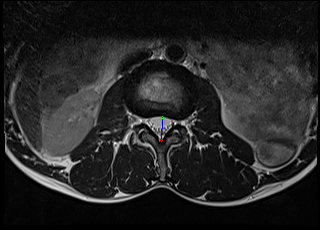

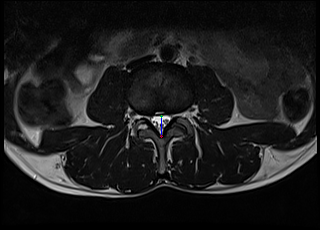

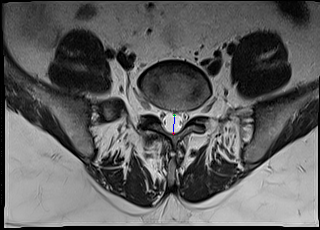

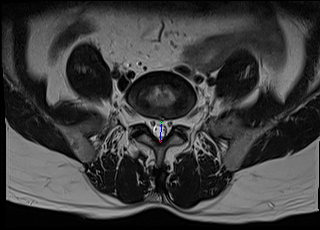

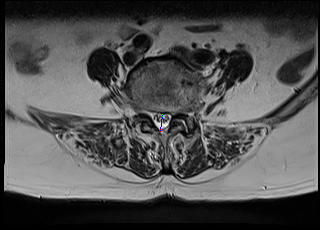

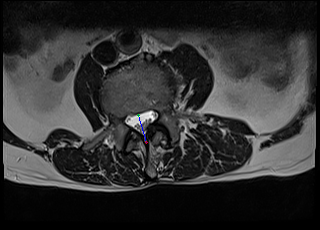

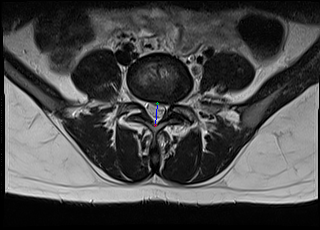

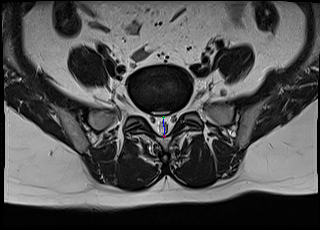

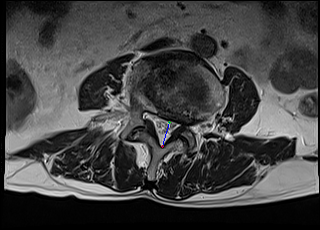

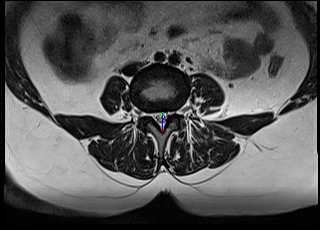

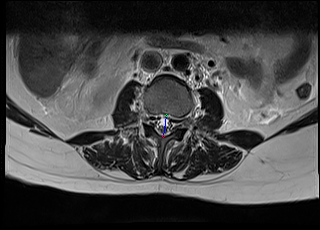

In [ ]:
# Just want to have these images, code can be ignored
#test for reference dataframe 
# from google.colab.patches import cv2_imshow
# for row in df_ref.iterrows():
#   # print(row)
#   img = cv2.imread(row[1][1])
#   img = cv2.circle(img, [_ for _ in row[1][2]], 1, (0,250,0), 1)
#   img = cv2.circle(img, [_ for _ in row[1][3]], 1, (0,0,250), 1)
#   cv2_imshow(img)
